# Inizializzazione

In [7]:
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

In [8]:
summary = pd.read_csv("garmin_edge_820/summary.csv",sep=";")   
details = pd.read_csv("garmin_edge_820/4557226804_ACTIVITY_data.csv", sep=";")

In [12]:
# Pulizia dei dati
details =  details.drop(['left_power_phase[degrees]', 
                  'left_power_phase_peak[degrees]', 
                  'right_power_phase[degrees]', 
                  'right_power_phase_peak[degrees]',
                  'left_right_balance'], axis=1)
# convertire i valori di tempo in formato datetime
details['time'] = pd.to_datetime(details.pop('timestamp[s]'), unit='s').dt.time
details.set_index("time", inplace=True)
#calcolo il tempo trascorso dall'inizio dell'attività
details['time_since_start'] = 1
details['time_since_start'] = details['time_since_start'].cumsum().sub(1)
# calcolo le zone di frequenza cardiaca e di potenza dato il battito in input
def get_zone(rate, zones):
    for zone, (lower, upper) in enumerate(zones, start=1):
        if lower <= rate <= upper:
            return str(zone)
hr_zones = [(0, 128), (129, 146), (147, 156), (157, 165), (166, 174), (175, 179), (180, float('inf'))]
power_zones = [(0, 157), (158, 186), (187, 200), (201, 218), (219, 247), (248, 287), (288, float('inf'))]
details['hr_zone'] = details['heart_rate[bpm]'].apply(get_zone, zones=hr_zones).astype(str)
details['pwr_zone'] = details['power[watts]'].apply(get_zone, zones=power_zones).astype(str)
# Calcola la differenza di altitudine tra le righe adiacenti
details['altitude_diff'] = details['altitude[m]'] - details['altitude[m]'].shift(1)
details['distance_diff'] = details['distance[m]'] - details['distance[m]'].shift(1)
details[['altitude_diff', 'distance_diff']] = details[['altitude_diff', 'distance_diff']].fillna(0)
# Calcola la percentuale di pendenza
details['slope_percent'] = np.where(details['distance_diff'] == 0, 0, details['altitude_diff'] / details['distance_diff'] * 100)

In [ ]:
details.describe()

In [ ]:
details.dtypes

In [ ]:
details.isna().sum()

In [9]:
details['speed[m/s]'] = details['speed[m/s]'].fillna(details['speed[m/s]'].mean()) 

# Data Visualization

In [ ]:
plt.figure(figsize=(24, 6))
plt.plot(details['time_since_start'], details['power[watts]'], label="power")
plt.plot(details['time_since_start'], details['cadence[rpm]'], label="cadence")
plt.plot(details['time_since_start'], details['speed[m/s]'], label="speed")
plt.plot(details['time_since_start'], details['heart_rate[bpm]'], label="bpm")
plt.plot(details['time_since_start'], details['altitude[m]'], label="altitude")
plt.xlabel("tempo")
plt.legend()
plt.grid(True)
plt.show()

# Previsioni

## Previsione battito

### Regressione lineare

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

# definisco l'errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

In [ ]:
from sklearn.model_selection import train_test_split

X = details.drop('heart_rate[bpm]',axis=1)
y = details['heart_rate[bpm]']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()
lrm.fit(X_train, y_train)
print_eval(X_val, y_val, lrm)

In [ ]:
from sklearn.linear_model import Lasso
lsm = Lasso(alpha=0.3)
lsm.fit(X_train, y_train)
print_eval(X_val, y_val, lsm)

In [ ]:
from sklearn.linear_model import Ridge
rrm = Ridge(alpha=0.5)
rrm.fit(X_train, y_train)
print_eval(X_val, y_val, rrm)

In [ ]:
from sklearn.linear_model import ElasticNet
enm = ElasticNet(alpha=0.1, l1_ratio=0.5)
enm.fit(X_train, y_train)
print_eval(X_val, y_val, enm)

In [ ]:
pd.DataFrame({
    "linear": lrm.coef_,
    "ridge": rrm.coef_,
    "lasso": lsm.coef_
}, index=X_train.columns)

### Regressione Polinomiale

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [ ]:
lrm_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("linear", LinearRegression())
])
lrm_poly.fit(X_train, y_train)
print_eval(X_val, y_val, lrm_poly)

In [ ]:
lsm_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lasso", Lasso(alpha=0.7)) 
])
lsm_poly.fit(X_train, y_train)
print_eval(X_val, y_val, lsm_poly)

In [ ]:
rrm_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("ridge", Ridge(alpha=1))
])
rrm_poly.fit(X_train, y_train)
print_eval(X_val, y_val, rrm_poly)

In [ ]:
enm_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("elasticnet", ElasticNet(alpha=0.1, l1_ratio=0.5))
])
enm_poly.fit(X_train, y_train)
print_eval(X_val, y_val, enm_poly)

### Regressione polinomiale con standardizzazione

In [ ]:
from sklearn.preprocessing import StandardScaler

lrm_poly_std = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("std", StandardScaler()),
    ("linear", LinearRegression())
])
lrm_poly_std.fit(X_train, y_train)
print_eval(X_val, y_val, lrm_poly_std)

In [ ]:
lsm_poly_std = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("std", StandardScaler()),
    ("lasso", Lasso(alpha=0.7))
])
lsm_poly_std.fit(X_train, y_train)
print_eval(X_val, y_val, lsm_poly_std)

In [ ]:
rrm_poly_std = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("std", StandardScaler()),
    ("ridge", Ridge(alpha=1))
])
rrm_poly_std.fit(X_train, y_train)
print_eval(X_val, y_val, rrm_poly_std)

In [ ]:
enm_poly_std = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("std", StandardScaler()),
    ("elasticnet", ElasticNet(alpha=0.1, l1_ratio=0.5))
])
enm_poly_std.fit(X_train, y_train)
print_eval(X_val, y_val, enm_poly_std)

### Regressione con funzioni kernel

In [ ]:
from sklearn.kernel_ridge import KernelRidge

In [ ]:
krm_poly = Pipeline([
    ("std", StandardScaler()),
    ("kernel", KernelRidge(alpha=20, kernel="poly", degree=6))
])
krm_poly.fit(X_train, y_train)
print_eval(X_val, y_val, krm_poly)

In [ ]:
krm_rbf = Pipeline([
    ("std", StandardScaler()),
    ("kernel", KernelRidge(alpha=0.1, kernel="rbf", gamma=0.1))
])
krm_rbf.fit(X_train, y_train)
print_eval(X_val, y_val, krm_rbf)

### Cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
pd.DataFrame(cross_validate(lrm, X, y, cv=kf, return_train_score=True)).describe().loc[["mean", "std"]]

In [ ]:
pd.DataFrame(cross_validate(lrm_poly, X, y, cv=kf, return_train_score=True)).describe().loc[["mean", "std"]]

In [ ]:
pd.DataFrame(cross_validate(krm_rbf, X, y, cv=kf, return_train_score=True)).describe().loc[["mean", "std"]]

#### Fine tuning iperparametri

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
lassoCV = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("std", None),
    ("lasso", Lasso())
])

grid = {
    "poly__degree": np.arange(1, 5),
    "std": [None, StandardScaler()],
    "lasso__alpha": np.logspace(-3, 0, 10)
}

lasso_gs = GridSearchCV(lassoCV, grid, cv=kf, return_train_score=True)
lasso_gs.fit(X_train, y_train)
pd.DataFrame(lasso_gs.cv_results_).sort_values("mean_test_score", ascending=False)
print_eval(X_val, y_val, lasso_gs)

## Previsione Potenza

In [49]:
# Seleziona le colonne che saranno utilizzate come feature per la predizione
features = details.columns.drop(['distance[m]','power[watts]','altitude_diff','distance_diff','slope_percent', 'time_since_start','hr_zone','pwr_zone','accumulated_power[watts]','altitude[m]','temperature[C]','left_pco[mm]','right_pco[mm]'])

# Seleziona la colonna come target
target = 'power[watts]'

# Dividi il dataset in set di addestramento e set di test
X_train, X_test, y_train, y_test = train_test_split(details[features], details[target], test_size=0.2, random_state=42)

# Crea un'istanza del modello di regressione lineare
model = Pipeline([
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),
    ("linear", LinearRegression(n_jobs=-1))
])

# Addestra il modello sui dati di addestramento
model.fit(X_train, y_train)

# Effettua la predizione sul set di test
y_pred = model.predict(X_test)

# Calcola l'errore medio quadratico
mse = mean_squared_error(y_test, y_pred)
print("Errore medio quadratico:", mse)

# Ora puoi utilizzare il modello addestrato per predire nuovi dati
new_data = pd.DataFrame([[4,140,90]], columns=features)
watts_pred = model.predict(new_data)
print("Potenza predetta:", watts_pred)

Errore medio quadratico: 5079.920608958543
Potenza predetta: [156.74114614]


# Classificazione

## Classificazione della potenza

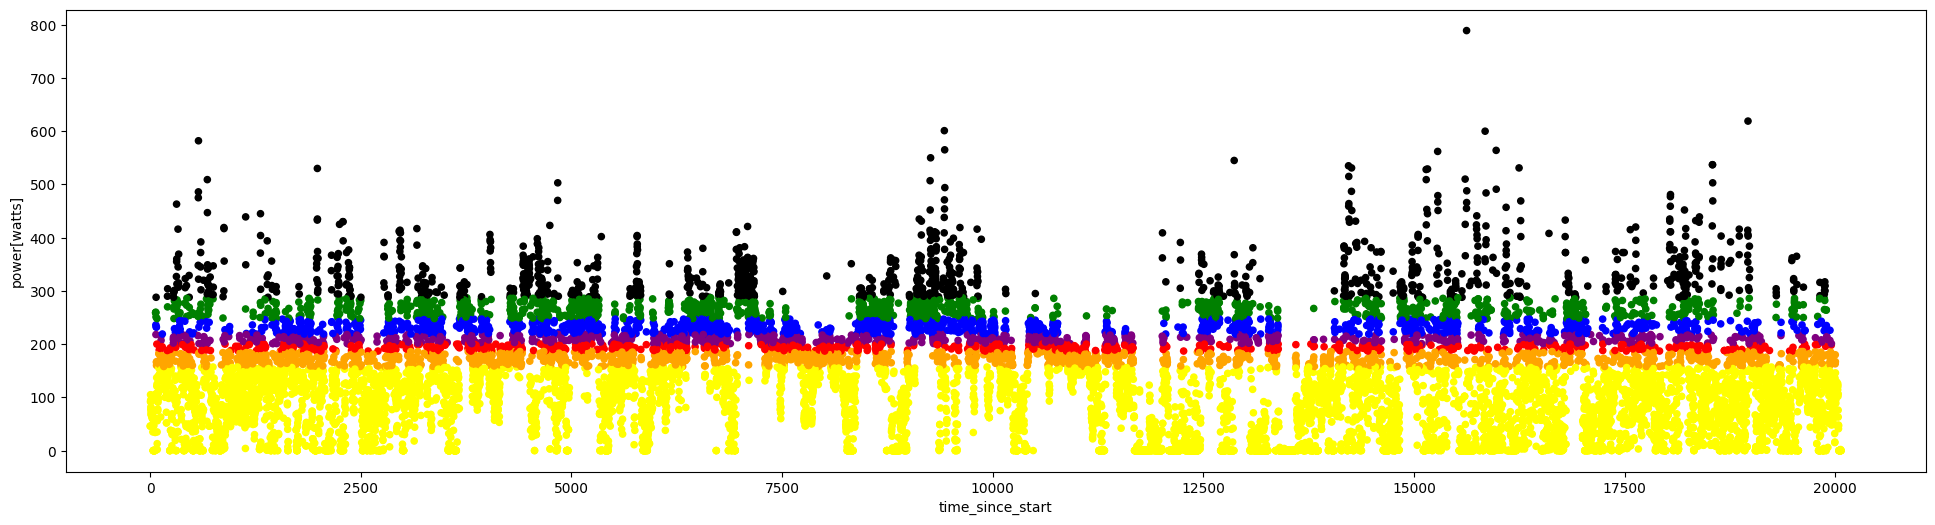

In [42]:
X = details[["time_since_start","power[watts]"]]
y = details['pwr_zone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

diagnosis_color_map = {"1": "yellow", "2": "orange", "3": "red", "4": "purple", "5": "blue", "6": "green", "7": "black"}
X_train.plot.scatter("time_since_start","power[watts]",
c=y_train.map(diagnosis_color_map),
figsize=(24,6));

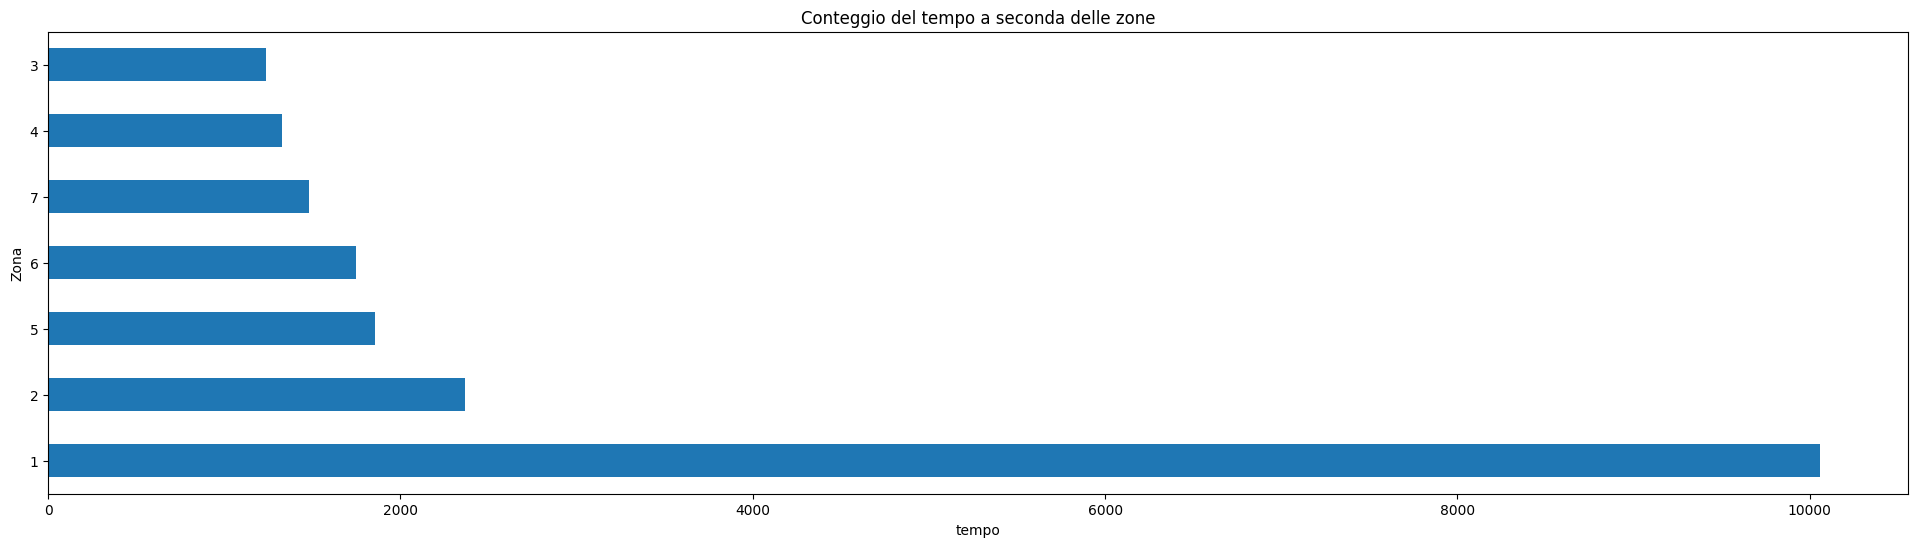

In [43]:
zone_counts = details['pwr_zone'].value_counts()

zone_counts.plot.barh(figsize=(24, 6), legend=None)

plt.xlabel('tempo')
plt.ylabel('Zona')
plt.title('Conteggio del tempo a seconda delle zone')
plt.show()

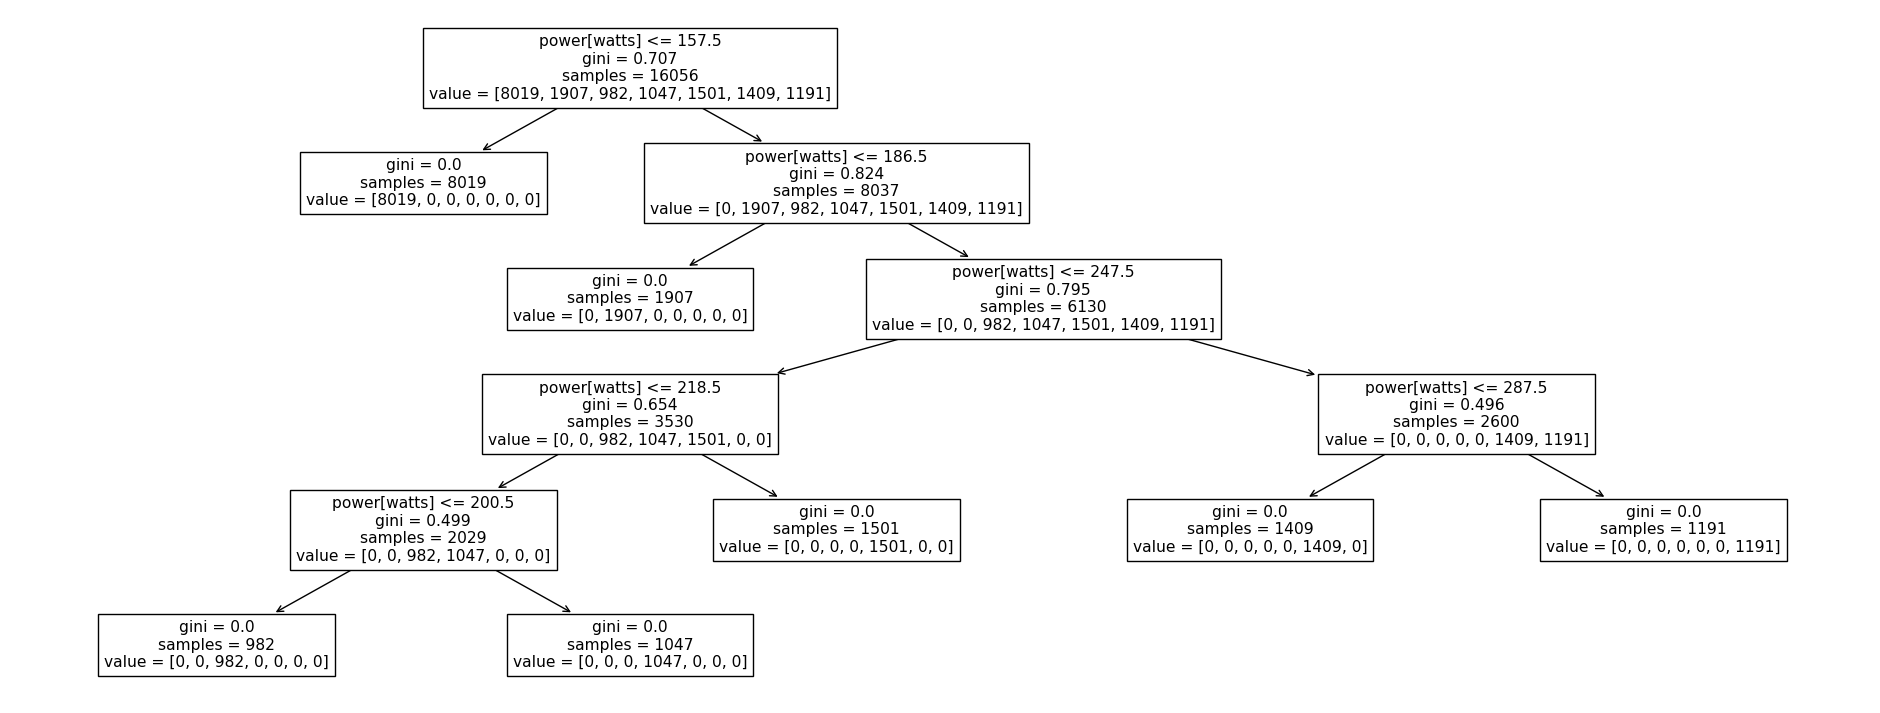

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

X = details.drop(['pwr_zone'], axis=1)
y = details['pwr_zone']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(max_depth=7)
model.fit(X_train, y_train);

plt.figure(figsize=(24, 9))
plot_tree(model, feature_names=X_train.columns.to_list());